In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random


In [2]:
#IMPORT OUR LIBRARIES
import dataloader
import best_classif_model

cudnn.benchmark = True


In [3]:
#LOAD DATASET
dataset = dataloader.MusicDataset('Data/genres_original','Data/features_30_sec.csv')

Loading:  50  items from dataset
Loading:  100  items from dataset
Loading:  150  items from dataset
Loading:  200  items from dataset
Loading:  250  items from dataset
Loading:  300  items from dataset


In [4]:
#RESNET BLOCK

class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

In [5]:
#MODEL - GENERATOR
class Generator(nn.Module):
    
    def __init__(self, num_classes=8, conv_dim=64, repeat_num=6):
        super(Generator, self).__init__()
        
        c_dim = num_classes
        
        #upp sampling
        layers = []
        layers.append(nn.Conv2d(1+c_dim, conv_dim, kernel_size=(3, 9), padding=(1, 4), bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(curr_dim, curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 1, kernel_size=7, stride=1, padding=3, bias=False))
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


In [6]:
#MODEL - DISKRIMINATOR

class Discriminator(nn.Module):
    
    def __init__(self, num_classes):
        super(Discriminator,self).__init__()
        modules = []

        modules.append(nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(8))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(32))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(64))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(32))
        modules.append(nn.ReLU(inplace = True))
        
        
        modules.append(nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU(inplace = True))
        
        modules.append(nn.AdaptiveAvgPool2d(output_size = 1))

        self.fc=nn.Linear(in_features=16,out_features=1,bias=False)
        
        self.fc_classif = nn.Linear(in_features=16, out_features = num_classes,bias=False)
        
        self.sequence = nn.Sequential(*modules)


    def forward(self,x):
        y = self.sequence(x)
        y = torch.flatten(y,start_dim=1)
        predict_fake = nn.Sigmoid()(self.fc(y))
        predict_genre = nn.Softmax()(self.fc_classif(y))
        return predict_genre, predict_fake
 

In [7]:
#CREATE INSTANCES

torch.cuda.empty_cache()

discriminator = Discriminator(len(dataset.classes))
generator = Generator(num_classes = len(dataset.classes))
#LOAD SOMETHING
discriminator.load_state_dict(torch.load("C:\\Users\\psimluser\\Desktop\\PSIML6_Voice_style_transfer\\diskriminator_3cls_ident0.pt"))
generator.load_state_dict(torch.load("C:\\Users\\psimluser\\Desktop\\PSIML6_Voice_style_transfer\\generator_3cls_ident0.pt"))
#LOAD BEST CLASSIFIER
#classifier = best_classif_model.Classifier(len(dataset.classes))
#PATH = "model_best.pt"
#classifier.load_state_dict(torch.load(PATH))

#DEVICE
device = torch.device('cuda:1')
discriminator = discriminator.cuda(1)
generator = generator.cuda(1)

In [8]:
#CHECK - getitem and discriminator
name, spect, mean,var,label = dataset.__getitem__(1)
spect = spect.reshape(1,spect.size(0),spect.size(1),spect.size(2))

spect = spect.to(device)

y = discriminator(spect)
print(y)

(tensor([[0.3431, 0.3107, 0.3462]], device='cuda:1', grad_fn=<SoftmaxBackward>), tensor([[0.5695]], device='cuda:1', grad_fn=<SigmoidBackward>))


C:\Anaconda\envs\psiml_gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
#CHECK - generator
label_onehot = torch.zeros(len(dataset.classes)) 
label_onehot[label] = 1
label_onehot = label_onehot.reshape(1,-1)
label_onehot = label_onehot.to(device)
y = generator(spect,label_onehot)
print(y.shape)
print(spect.shape)

torch.Size([1, 1, 220, 1280])
torch.Size([1, 1, 220, 1280])


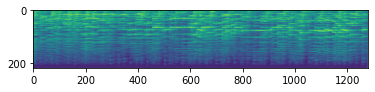

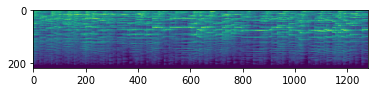

In [10]:
#CHECK - plot starting point and real recording

y = y.detach().cpu().numpy().reshape(y.size(2),y.size(3))
spect = spect.detach().cpu().numpy().reshape(spect.size(2),spect.size(3))
var = var.cpu().numpy()
mean = mean.cpu().numpy()
spect = spect*var+mean
y = y*var+mean
plt.imshow(y)
plt.show()
plt.imshow(spect)


In [28]:
#TRAIN PARAMETERS

num_epochs = 1000
batch_size = 3
num_workers = 0
# make train and valid splits

random.seed(0)  # rng seed, set to 0 for reproducibility

dataset_indices = list(range(len(dataset)))
random.shuffle(dataset_indices)  # shuffle the indices before splitting (use random.shuffle)

#split datasets
train_split_indices = dataset_indices[:int(len(dataset_indices)*0.8)]  # get the training split indices
#valid_split_indices = dataset_indices[int(len(dataset_indices)*0.6):int(len(dataset_indices)*0.8)]  # get the validation split indices 
#test_split_indices = dataset_indices[int(len(dataset_indices)*0.8):]

train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
#valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)
#test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_split_indices)

train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers, drop_last=True)


d_learning_rate=0.0001
g_learning_rate=0.0001
g_optimizer = torch.optim.Adam(generator.parameters(),lr=d_learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=g_learning_rate)
g_optim_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, mode='min', factor=1.0/3.16227766, patience=5,verbose=True, threshold=0.0001, threshold_mode='rel',cooldown=0, min_lr=0, eps=1e-08)
d_optim_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(d_optimizer, mode='min', factor=1.0/3.16227766, patience=5,verbose=True, threshold=0.0001, threshold_mode='rel',cooldown=0, min_lr=0, eps=1e-08)


n_disc = 10
    

C:\Anaconda\envs\psiml_gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Discriminator:
loss_real= -0.8979722261428833
loss_fake= 0.8909168243408203
loss_class= 0.5543474555015564
loss_disc= 1.6559869050979614
Generator:
loss_fake= -0.8689939975738525
loss_class= 0.6068921089172363
loss_cycle= 0.4882242977619171
loss_ident= 0.45060333609580994
loss_gen= 2.3787341117858887

loss_disc= 1.6559869050979614
loss_gen =  2.3787341117858887


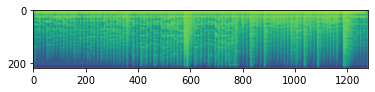

Discriminator:
loss_real= -0.888905942440033
loss_fake= 0.5373272895812988
loss_class= 0.554697573184967
loss_disc= 1.312514066696167
Generator:
loss_fake= -0.5334855318069458
loss_class= 0.5963699817657471
loss_cycle= 0.4265930652618408
loss_ident= 0.400211900472641
loss_gen= 2.5090222358703613
Discriminator:
loss_real= -0.8698400855064392
loss_fake= 0.5855077505111694
loss_class= 0.576176106929779
loss_disc= 1.4441959857940674
Generator:
loss_fake= -0.582019031047821
loss_class= 0.5620457530021667
loss_cycle= 0.41536006331443787
loss_ident= 0.3850748836994171
loss_gen= 2.319913148880005
Discriminator:
loss_real= -0.9115845561027527
loss_fake= 0.6767410635948181
loss_class= 0.9892671704292297
loss_disc= 2.7329580783843994
Generator:
loss_fake= -0.6766785383224487
loss_class= 0.5913083553314209
loss_cycle= 0.3783378601074219
loss_ident= 0.353503555059433
loss_gen= 2.207425832748413
Discriminator:
loss_real= -0.8879430294036865
loss_fake= 0.5796597599983215
loss_class= 0.574678242206573

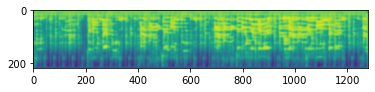

Discriminator:
loss_real= -0.9162144064903259
loss_fake= 0.5172976851463318
loss_class= 0.6062045693397522
loss_disc= 1.4196970462799072
Generator:
loss_fake= -0.514682948589325
loss_class= 0.5782623291015625
loss_cycle= 0.4448326826095581
loss_ident= 0.4087721109390259
loss_gen= 2.5185413360595703
Discriminator:
loss_real= -0.9141607284545898
loss_fake= 0.8789615631103516
loss_class= 0.5698277950286865
loss_disc= 1.6742842197418213
Generator:
loss_fake= -0.8739184141159058
loss_class= 0.6480620503425598
loss_cycle= 0.39402318000793457
loss_ident= 0.36340194940567017
loss_gen= 2.2217161655426025
Discriminator:
loss_real= -0.9158155918121338
loss_fake= 0.8819184303283691
loss_class= 0.5772324204444885
loss_disc= 1.6978001594543457
Generator:
loss_fake= -0.8791348338127136
loss_class= 0.6355761289596558
loss_cycle= 0.4640573561191559
loss_ident= 0.42461130023002625
loss_gen= 2.380319595336914
Discriminator:
loss_real= -0.8780738115310669
loss_fake= 0.7990292310714722
loss_class= 0.572877

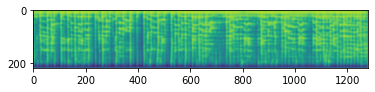

Discriminator:
loss_real= -0.9108648300170898
loss_fake= 0.4704030156135559
loss_class= 0.592414140701294
loss_disc= 1.3367805480957031
Generator:
loss_fake= -0.4696381688117981
loss_class= 0.6017824411392212
loss_cycle= 0.38419094681739807
loss_ident= 0.3548027276992798
loss_gen= 2.4588937759399414
Discriminator:
loss_real= -0.873863935470581
loss_fake= 0.6310677528381348
loss_class= 0.5782660245895386
loss_disc= 1.4920018911361694
Generator:
loss_fake= -0.6277123689651489
loss_class= 0.5667880773544312
loss_cycle= 0.41044920682907104
loss_ident= 0.38638201355934143
loss_gen= 2.2799322605133057
Discriminator:
loss_real= -0.9234628677368164
loss_fake= 0.7885137796401978
loss_class= 0.6351397037506104
loss_disc= 1.7704700231552124
Generator:
loss_fake= -0.7773466110229492
loss_class= 0.5997495055198669
loss_cycle= 0.420271635055542
loss_ident= 0.38926032185554504
loss_gen= 2.2517054080963135
Discriminator:
loss_real= -0.8948904871940613
loss_fake= 0.8806780576705933
loss_class= 0.575192

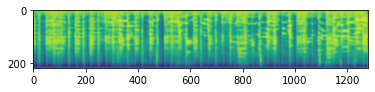

Discriminator:
loss_real= -0.9168767929077148
loss_fake= 0.6229392290115356
loss_class= 0.5564464330673218
loss_disc= 1.3754017353057861
Generator:
loss_fake= -0.6222175359725952
loss_class= 0.5765219330787659
loss_cycle= 0.4530865252017975
loss_ident= 0.41677528619766235
loss_gen= 2.4302966594696045
Discriminator:
loss_real= -0.9258565902709961
loss_fake= 0.455901563167572
loss_class= 0.5720129013061523
loss_disc= 1.2460837364196777
Generator:
loss_fake= -0.45503947138786316
loss_class= 0.6040137410163879
loss_cycle= 0.4044867157936096
loss_ident= 0.37720370292663574
loss_gen= 2.5431787967681885
Discriminator:
loss_real= -0.9204489588737488
loss_fake= 0.8841619491577148
loss_class= 0.5537996292114258
loss_disc= 1.6251118183135986
Generator:
loss_fake= -0.8830373287200928
loss_class= 1.1252655982971191
loss_cycle= 0.37801438570022583
loss_ident= 0.3495585024356842
loss_gen= 3.5983469486236572
Discriminator:
loss_real= -0.9165334105491638
loss_fake= 0.6334485411643982
loss_class= 0.5916

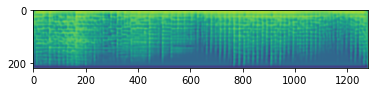

Discriminator:
loss_real= -0.9100731611251831
loss_fake= 0.8910195231437683
loss_class= 0.5799344182014465
loss_disc= 1.7207496166229248
Generator:
loss_fake= -0.8793822526931763
loss_class= 0.6873616576194763
loss_cycle= 0.3971366882324219
loss_ident= 0.3615643084049225
loss_gen= 2.3385403156280518
Discriminator:
loss_real= -0.8810243606567383
loss_fake= 0.49550580978393555
loss_class= 0.5961067080497742
loss_disc= 1.402801513671875
Generator:
loss_fake= -0.49189433455467224
loss_class= 0.6399032473564148
loss_cycle= 0.43436723947525024
loss_ident= 0.40315333008766174
loss_gen= 2.6997032165527344
Discriminator:
loss_real= -0.8881167769432068
loss_fake= 0.5192722678184509
loss_class= 0.6065952777862549
loss_disc= 1.4509413242340088
Generator:
loss_fake= -0.5153249502182007
loss_class= 0.6355224251747131
loss_cycle= 0.46391957998275757
loss_ident= 0.42570504546165466
loss_gen= 2.744786500930786
Discriminator:
loss_real= -0.8912340998649597
loss_fake= 0.5285412073135376
loss_class= 0.577

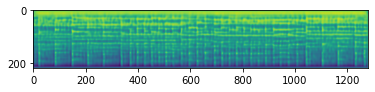

Discriminator:
loss_real= -0.9132426977157593
loss_fake= 0.47283464670181274
loss_class= 0.5747509598731995
loss_disc= 1.2838449478149414
Generator:
loss_fake= -0.46917957067489624
loss_class= 0.7202813029289246
loss_cycle= 0.48352742195129395
loss_ident= 0.44960078597068787
loss_gen= 3.1083197593688965
Discriminator:
loss_real= -0.9176890254020691
loss_fake= 0.46551012992858887
loss_class= 0.5679226517677307
loss_disc= 1.251589059829712
Generator:
loss_fake= -0.46305930614471436
loss_class= 0.7398499846458435
loss_cycle= 0.4688679575920105
loss_ident= 0.4412289559841156
loss_gen= 3.135455369949341
Discriminator:
loss_real= -0.9188560247421265
loss_fake= 0.7037652730941772
loss_class= 0.5736798644065857
loss_disc= 1.505948781967163
Generator:
loss_fake= -0.7037690877914429
loss_class= 0.8030672073364258
loss_cycle= 0.3674568831920624
loss_ident= 0.32957619428634644
loss_gen= 2.7699224948883057
Discriminator:
loss_real= -0.8734784126281738
loss_fake= 0.7410606741905212
loss_class= 0.600

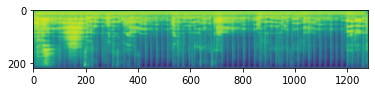

Discriminator:
loss_real= -0.8777351379394531
loss_fake= 0.5751960873603821
loss_class= 0.5899258255958557
loss_disc= 1.467238426208496
Generator:
loss_fake= -0.5707410573959351
loss_class= 0.5857617259025574
loss_cycle= 0.4034275412559509
loss_ident= 0.3679749667644501
loss_gen= 2.3613741397857666
Discriminator:
loss_real= -0.9191521406173706
loss_fake= 0.6746609210968018
loss_class= 0.5554190278053284
loss_disc= 1.421765923500061
Generator:
loss_fake= -0.6744955778121948
loss_class= 0.6363006234169006
loss_cycle= 0.4153987765312195
loss_ident= 0.37753811478614807
loss_gen= 2.442742109298706
Discriminator:
loss_real= -0.9117352962493896
loss_fake= 0.8117453455924988
loss_class= 0.572820246219635
loss_disc= 1.6184709072113037
Generator:
loss_fake= -0.8106656074523926
loss_class= 1.0149632692337036
loss_cycle= 0.46119222044944763
loss_ident= 0.43067583441734314
loss_gen= 3.587284564971924
Discriminator:
loss_real= -0.9249774217605591
loss_fake= 0.6719200015068054
loss_class= 0.573197245

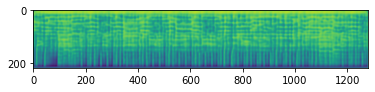

Discriminator:
loss_real= -0.9205777645111084
loss_fake= 0.4693790376186371
loss_class= 0.5572446584701538
loss_disc= 1.2205352783203125
Generator:
loss_fake= -0.4642389714717865
loss_class= 0.6697704195976257
loss_cycle= 0.4220484495162964
loss_ident= 0.38845768570899963
loss_gen= 2.7776269912719727
Discriminator:
loss_real= -0.9039568305015564
loss_fake= 0.8868472576141357
loss_class= 0.577103316783905
loss_disc= 1.7142002582550049
Generator:
loss_fake= -0.8857991099357605
loss_class= 0.9603254795074463
loss_cycle= 0.4278119206428528
loss_ident= 0.38990285992622375
loss_gen= 3.240703821182251
Discriminator:
loss_real= -0.9104423522949219
loss_fake= 0.6030957698822021
loss_class= 0.5786415934562683
loss_disc= 1.4285781383514404
Generator:
loss_fake= -0.6026725172996521
loss_class= 0.5950638055801392
loss_cycle= 0.42466920614242554
loss_ident= 0.3843085765838623
loss_gen= 2.416166067123413
Discriminator:
loss_real= -0.9150875806808472
loss_fake= 0.4551796615123749
loss_class= 0.5554187

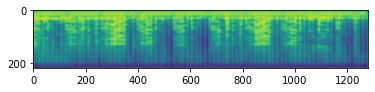

Discriminator:
loss_real= -0.9245079755783081
loss_fake= 0.8851561546325684
loss_class= 0.5724353194236755
loss_disc= 1.677954077720642
Generator:
loss_fake= -0.883091926574707
loss_class= 0.7857513427734375
loss_cycle= 0.4223279058933258
loss_ident= 0.3909197449684143
loss_gen= 2.709737539291382
Discriminator:
loss_real= -0.9277924299240112
loss_fake= 0.8529073596000671
loss_class= 0.5792365074157715
loss_disc= 1.6628243923187256
Generator:
loss_fake= -0.8516390323638916
loss_class= 0.6549505591392517
loss_cycle= 0.45313847064971924
loss_ident= 0.41389966011047363
loss_gen= 2.433389186859131
Discriminator:
loss_real= -0.8999406099319458
loss_fake= 0.6983903646469116
loss_class= 0.593048632144928
loss_disc= 1.5775957107543945
Generator:
loss_fake= -0.697716236114502
loss_class= 0.6612434983253479
loss_cycle= 0.43830233812332153
loss_ident= 0.40151071548461914
loss_gen= 2.5641298294067383
Discriminator:
loss_real= -0.8903701305389404
loss_fake= 0.8110092878341675
loss_class= 0.572561025

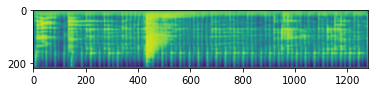

Discriminator:
loss_real= -0.9162358045578003
loss_fake= 0.5978617668151855
loss_class= 0.5545099377632141
loss_disc= 1.3451558351516724
Generator:
loss_fake= -0.5965646505355835
loss_class= 0.581515371799469
loss_cycle= 0.4564436972141266
loss_ident= 0.4135487377643585
loss_gen= 2.4744176864624023
Discriminator:
loss_real= -0.9196652770042419
loss_fake= 0.8167945742607117
loss_class= 0.5755579471588135
loss_disc= 1.6238031387329102
Generator:
loss_fake= -0.8128269910812378
loss_class= 0.5970287919044495
loss_cycle= 0.37152722477912903
loss_ident= 0.33694446086883545
loss_gen= 2.058258533477783
Discriminator:
loss_real= -0.9188745021820068
loss_fake= 0.862380862236023
loss_class= 0.605096161365509
loss_disc= 1.758794903755188
Generator:
loss_fake= -0.8611307144165039
loss_class= 1.0847886800765991
loss_cycle= 0.4060315787792206
loss_ident= 0.37102222442626953
loss_gen= 3.5763206481933594
Discriminator:
loss_real= -0.8910508155822754
loss_fake= 0.6633302569389343
loss_class= 0.560503304

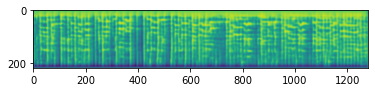

Discriminator:
loss_real= -0.8693771362304688
loss_fake= 0.47457367181777954
loss_class= 0.6113965511322021
loss_disc= 1.4393861293792725
Generator:
loss_fake= -0.4736917018890381
loss_class= 0.7271342277526855
loss_cycle= 0.468241810798645
loss_ident= 0.42142555117607117
loss_gen= 3.065620183944702
Discriminator:
loss_real= -0.9224985837936401
loss_fake= 0.41644883155822754
loss_class= 0.5977433323860168
loss_disc= 1.2871803045272827
Generator:
loss_fake= -0.41616091132164
loss_class= 0.6168210506439209
loss_cycle= 0.4007687568664551
loss_ident= 0.378389835357666
loss_gen= 2.614229679107666
Discriminator:
loss_real= -0.862358570098877
loss_fake= 0.43775463104248047
loss_class= 0.5879418253898621
loss_disc= 1.339221477508545
Generator:
loss_fake= -0.43733322620391846
loss_class= 0.5961737036705017
loss_cycle= 0.3956480622291565
loss_ident= 0.37405237555503845
loss_gen= 2.516536235809326
Discriminator:
loss_real= -0.913759171962738
loss_fake= 0.6559738516807556
loss_class= 0.55497729778

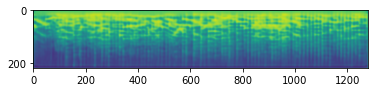

Discriminator:
loss_real= -0.9380235075950623
loss_fake= 0.6877232789993286
loss_class= 1.0795811414718628
loss_disc= 2.98844313621521
Generator:
loss_fake= -0.6852215528488159
loss_class= 0.5706674456596375
loss_cycle= 0.4602660536766052
loss_ident= 0.416691392660141
loss_gen= 2.364004135131836
Discriminator:
loss_real= -0.852506160736084
loss_fake= 0.5659952163696289
loss_class= 0.5989568829536438
loss_disc= 1.510359764099121
Generator:
loss_fake= -0.5649619102478027
loss_class= 0.5677276253700256
loss_cycle= 0.4218701124191284
loss_ident= 0.38356393575668335
loss_gen= 2.365525245666504
Discriminator:
loss_real= -0.8980967402458191
loss_fake= 0.7255460619926453
loss_class= 0.5881887078285217
loss_disc= 1.5920155048370361
Generator:
loss_fake= -0.724819540977478
loss_class= 0.6110420823097229
loss_cycle= 0.4593333899974823
loss_ident= 0.4266277849674225
loss_gen= 2.453601360321045
Discriminator:
loss_real= -0.9129832983016968
loss_fake= 0.5158745050430298
loss_class= 0.573692262172699

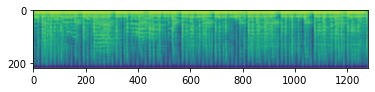

Discriminator:
loss_real= -0.9092270731925964
loss_fake= 0.7233414053916931
loss_class= 0.5778091549873352
loss_disc= 1.547541856765747
Generator:
loss_fake= -0.7222690582275391
loss_class= 0.6410620808601379
loss_cycle= 0.48381754755973816
loss_ident= 0.4585423469543457
loss_gen= 2.6270947456359863
Discriminator:
loss_real= -0.8915976881980896
loss_fake= 0.7462999224662781
loss_class= 0.5797306299209595
loss_disc= 1.593894124031067
Generator:
loss_fake= -0.7444502711296082
loss_class= 0.6149826645851135
loss_cycle= 0.4976123869419098
loss_ident= 0.46394526958465576
loss_gen= 2.5596675872802734
Discriminator:
loss_real= -0.8928594589233398
loss_fake= 0.423598051071167
loss_class= 0.5743806958198547
loss_disc= 1.2538807392120361
Generator:
loss_fake= -0.4230784773826599
loss_class= 0.5891920924186707
loss_cycle= 0.40429937839508057
loss_ident= 0.37894561886787415
loss_gen= 2.5320420265197754
Discriminator:
loss_real= -0.893958568572998
loss_fake= 0.7223092317581177
loss_class= 0.5785465

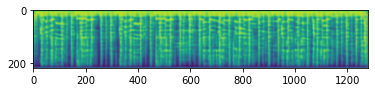

Discriminator:
loss_real= -0.9223718643188477
loss_fake= 0.6702584028244019
loss_class= 0.5545900464057922
loss_disc= 1.4116567373275757
Generator:
loss_fake= -0.6702152490615845
loss_class= 0.6454100608825684
loss_cycle= 0.42889484763145447
loss_ident= 0.40520256757736206
loss_gen= 2.5290071964263916
Discriminator:
loss_real= -0.8907712697982788
loss_fake= 0.6959527730941772
loss_class= 0.5787668824195862
loss_disc= 1.5414822101593018
Generator:
loss_fake= -0.6952416300773621
loss_class= 0.610442578792572
loss_cycle= 0.43643200397491455
loss_ident= 0.40336722135543823
loss_gen= 2.4123172760009766
Discriminator:
loss_real= -0.8135714530944824
loss_fake= 0.7082444429397583
loss_class= 0.6033432483673096
loss_disc= 1.7047027349472046
Generator:
loss_fake= -0.7069950103759766
loss_class= 0.5886196494102478
loss_cycle= 0.4204528033733368
loss_ident= 0.392884224653244
loss_gen= 2.292653799057007
Discriminator:
loss_real= -0.9212073683738708
loss_fake= 0.7988858222961426
loss_class= 0.555623

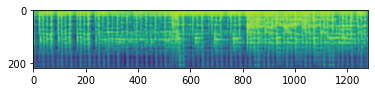

Discriminator:
loss_real= -0.8652993440628052
loss_fake= 0.7977750301361084
loss_class= 0.6050417423248291
loss_disc= 1.7476009130477905
Generator:
loss_fake= -0.7978763580322266
loss_class= 0.6129234433174133
loss_cycle= 0.4045165181159973
loss_ident= 0.37903448939323425
loss_gen= 2.22896146774292
Discriminator:
loss_real= -0.8502724170684814
loss_fake= 0.47419044375419617
loss_class= 0.5894133448600769
loss_disc= 1.392158031463623
Generator:
loss_fake= -0.4740395247936249
loss_class= 0.6294322609901428
loss_cycle= 0.397177517414093
loss_ident= 0.3642089068889618
loss_gen= 2.5728213787078857
Discriminator:
loss_real= -0.8154668807983398
loss_fake= 0.9005532264709473
loss_class= 0.5879074931144714
loss_disc= 1.848808765411377
Generator:
loss_fake= -0.9005209803581238
loss_class= 0.6968023777008057
loss_cycle= 0.41175907850265503
loss_ident= 0.37788456678390503
loss_gen= 2.391288995742798
Discriminator:
loss_real= -0.9223272204399109
loss_fake= 0.8258113861083984
loss_class= 0.611339807

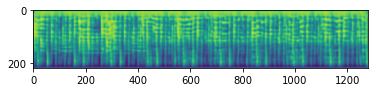

Discriminator:
loss_real= -0.9142090082168579
loss_fake= 0.6887603998184204
loss_class= 0.6029925346374512
loss_disc= 1.583528995513916
Generator:
loss_fake= -0.688563346862793
loss_class= 0.5634095072746277
loss_cycle= 0.4015282094478607
loss_ident= 0.3870740830898285
loss_gen= 2.191795587539673
Discriminator:
loss_real= -0.8644882440567017
loss_fake= 0.8442447185516357
loss_class= 0.5535249710083008
loss_disc= 1.6403313875198364
Generator:
loss_fake= -0.8436936140060425
loss_class= 0.641259491443634
loss_cycle= 0.41624292731285095
loss_ident= 0.3903031051158905
loss_gen= 2.3028738498687744
Discriminator:
loss_real= -0.9153465628623962
loss_fake= 0.630199670791626
loss_class= 0.5548059940338135
loss_disc= 1.3792710304260254
Generator:
loss_fake= -0.6296001672744751
loss_class= 0.5922872424125671
loss_cycle= 0.4274798035621643
loss_ident= 0.3930836021900177
loss_gen= 2.3953046798706055
Discriminator:
loss_real= -0.9090204238891602
loss_fake= 0.838009238243103
loss_class= 0.554388821125

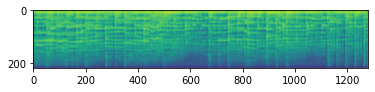

Discriminator:
loss_real= -0.9012470245361328
loss_fake= 0.8654931783676147
loss_class= 0.5897485017776489
loss_disc= 1.7334916591644287
Generator:
loss_fake= -0.8653208017349243
loss_class= 1.0658940076828003
loss_cycle= 0.4481184780597687
loss_ident= 0.4024694859981537
loss_gen= 3.6310675144195557
Discriminator:
loss_real= -0.896338939666748
loss_fake= 0.8799192309379578
loss_class= 0.5953608155250549
loss_disc= 1.769662857055664
Generator:
loss_fake= -0.8796310424804688
loss_class= 0.6470887064933777
loss_cycle= 0.42743009328842163
loss_ident= 0.40146246552467346
loss_gen= 2.317957639694214
Discriminator:
loss_real= -0.9007266759872437
loss_fake= 0.8672103881835938
loss_class= 0.5570084452629089
loss_disc= 1.6375089883804321
Generator:
loss_fake= -0.866848349571228
loss_class= 1.0992475748062134
loss_cycle= 0.4403879642486572
loss_ident= 0.3994923233985901
loss_gen= 3.711162567138672
Discriminator:
loss_real= -0.9314748644828796
loss_fake= 0.8191871047019958
loss_class= 0.5797081589

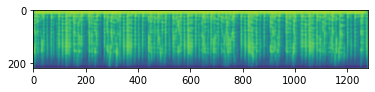

Discriminator:
loss_real= -0.8663996458053589
loss_fake= 0.8210681676864624
loss_class= 0.5790878534317017
loss_disc= 1.6919320821762085
Generator:
loss_fake= -0.8208414912223816
loss_class= 1.0708221197128296
loss_cycle= 0.44784802198410034
loss_ident= 0.41795817017555237
loss_gen= 3.7052788734436035
Discriminator:
loss_real= -0.8919776678085327
loss_fake= 0.714198112487793
loss_class= 0.5560178160667419
loss_disc= 1.4902738332748413
Generator:
loss_fake= -0.7134637236595154
loss_class= 0.582582950592041
loss_cycle= 0.3704769015312195
loss_ident= 0.34524473547935486
loss_gen= 2.120483636856079
Discriminator:
loss_real= -0.9184036254882812
loss_fake= 0.9215973615646362
loss_class= 0.5545042157173157
loss_disc= 1.6667064428329468
Generator:
loss_fake= -0.9215793013572693
loss_class= 1.1686972379684448
loss_cycle= 0.42656272649765015
loss_ident= 0.3953380286693573
loss_gen= 3.8329758644104004
Discriminator:
loss_real= -0.9001757502555847
loss_fake= 0.6299188733100891
loss_class= 0.554279

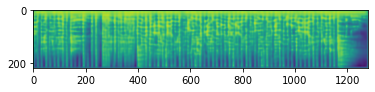

Discriminator:
loss_real= -0.912750244140625
loss_fake= 0.7682228088378906
loss_class= 0.5548651218414307
loss_disc= 1.5200679302215576
Generator:
loss_fake= -0.7679516673088074
loss_class= 0.6647104024887085
loss_cycle= 0.378351092338562
loss_ident= 0.3507165312767029
loss_gen= 2.3335983753204346
Discriminator:
loss_real= -0.8326448202133179
loss_fake= 0.6806649565696716
loss_class= 0.5555853843688965
loss_disc= 1.5147762298583984
Generator:
loss_fake= -0.6806219816207886
loss_class= 0.5974568724632263
loss_cycle= 0.37730488181114197
loss_ident= 0.3478800356388092
loss_gen= 2.214238405227661
Discriminator:
loss_real= -0.8688840866088867
loss_fake= 0.8923895359039307
loss_class= 0.5775471329689026
loss_disc= 1.7561469078063965
Generator:
loss_fake= -0.8923488855361938
loss_class= 1.0003657341003418
loss_cycle= 0.3912542164325714
loss_ident= 0.3587249219417572
loss_gen= 3.249981641769409
Discriminator:
loss_real= -0.8970993757247925
loss_fake= 0.715481698513031
loss_class= 0.57366245985

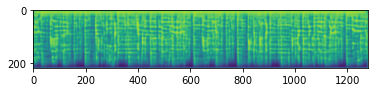

Discriminator:
loss_real= -0.9020048975944519
loss_fake= 0.6429080367088318
loss_class= 0.5545095205307007
loss_disc= 1.404431700706482
Generator:
loss_fake= -0.6425490379333496
loss_class= 0.5846299529075623
loss_cycle= 0.43089762330055237
loss_ident= 0.3996701240539551
loss_gen= 2.3728060722351074
Discriminator:
loss_real= -0.8951193690299988
loss_fake= 0.723570704460144
loss_class= 0.5807933211326599
loss_disc= 1.570831298828125
Generator:
loss_fake= -0.7234295606613159
loss_class= 0.5864713191986084
loss_cycle= 0.39000430703163147
loss_ident= 0.3608316481113434
loss_gen= 2.1768248081207275
Discriminator:
loss_real= -0.8716718554496765
loss_fake= 0.7073456048965454
loss_class= 0.5821508169174194
loss_disc= 1.5821261405944824
Generator:
loss_fake= -0.7067497968673706
loss_class= 0.5606699585914612
loss_cycle= 0.41098514199256897
loss_ident= 0.37926796078681946
loss_gen= 2.1764984130859375
Discriminator:
loss_real= -0.9022383689880371
loss_fake= 0.8869462013244629
loss_class= 0.554853

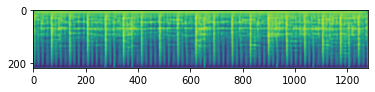

Discriminator:
loss_real= -0.8974887132644653
loss_fake= 0.7610445022583008
loss_class= 0.6064695715904236
loss_disc= 1.6829644441604614
Generator:
loss_fake= -0.7608842849731445
loss_class= 0.6391972899436951
loss_cycle= 0.3973708152770996
loss_ident= 0.3706778287887573
loss_gen= 2.322126865386963
Discriminator:
loss_real= -0.9115225672721863
loss_fake= 0.7453820109367371
loss_class= 0.5541755557060242
loss_disc= 1.4963860511779785
Generator:
loss_fake= -0.7452523112297058
loss_class= 0.5996116995811462
loss_cycle= 0.40696877241134644
loss_ident= 0.38271328806877136
loss_gen= 2.2502334117889404
Discriminator:
loss_real= -0.9018592834472656
loss_fake= 0.49504849314689636
loss_class= 0.6007289886474609
loss_disc= 1.395376205444336
Generator:
loss_fake= -0.49493083357810974
loss_class= 0.5948088765144348
loss_cycle= 0.4080595374107361
loss_ident= 0.37432950735092163
loss_gen= 2.4799444675445557
Discriminator:
loss_real= -0.9194741249084473
loss_fake= 0.8795160055160522
loss_class= 1.0633

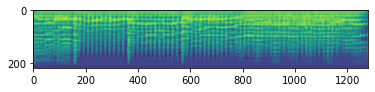

Discriminator:
loss_real= -0.9066290855407715
loss_fake= 0.8913801908493042
loss_class= 0.6059433817863464
loss_disc= 1.8025811910629272
Generator:
loss_fake= -0.8913502097129822
loss_class= 1.0323759317398071
loss_cycle= 0.390170156955719
loss_ident= 0.36419227719306946
loss_gen= 3.3503100872039795
Discriminator:
loss_real= -0.9192584753036499
loss_fake= 0.8084632158279419
loss_class= 0.5689635872840881
loss_disc= 1.5960955619812012
Generator:
loss_fake= -0.8083127737045288
loss_class= 0.5851686596870422
loss_cycle= 0.4006494879722595
loss_ident= 0.3753035068511963
loss_gen= 2.123795747756958
Discriminator:
loss_real= -0.9234071969985962
loss_fake= 0.9045442342758179
loss_class= 0.5584250688552856
loss_disc= 1.6564122438430786
Generator:
loss_fake= -0.9044865965843201
loss_class= 0.614037275314331
loss_cycle= 0.40661516785621643
loss_ident= 0.3806252181529999
loss_gen= 2.1314806938171387
Discriminator:
loss_real= -0.8978061676025391
loss_fake= 0.8084490299224854
loss_class= 0.56771928

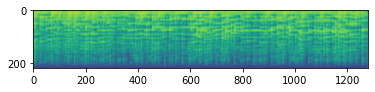

Discriminator:
loss_real= -0.8779417872428894
loss_fake= 0.904116153717041
loss_class= 0.5845232605934143
loss_disc= 1.7797441482543945
Generator:
loss_fake= -0.9041110277175903
loss_class= 0.6258931159973145
loss_cycle= 0.4493836462497711
loss_ident= 0.41284483671188354
loss_gen= 2.2851805686950684
Discriminator:
loss_real= -0.9213191866874695
loss_fake= 0.6680032014846802
loss_class= 1.0908528566360474
loss_disc= 3.019242763519287
Generator:
loss_fake= -0.667888343334198
loss_class= 0.5569837689399719
loss_cycle= 0.4480624198913574
loss_ident= 0.41666436195373535
loss_gen= 2.315852165222168
Discriminator:
loss_real= -0.9095630049705505
loss_fake= 0.89031982421875
loss_class= 0.5880813598632812
loss_disc= 1.7450008392333984
Generator:
loss_fake= -0.8902570605278015
loss_class= 1.0086196660995483
loss_cycle= 0.425890177488327
loss_ident= 0.40214473009109497
loss_gen= 3.389526844024658
Discriminator:
loss_real= -0.9178943634033203
loss_fake= 0.6827517747879028
loss_class= 0.587987005710

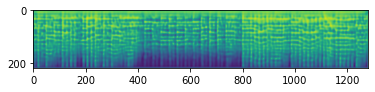

Discriminator:
loss_real= -0.9067225456237793
loss_fake= 0.7083587646484375
loss_class= 0.96552973985672
loss_disc= 2.698225498199463
Generator:
loss_fake= -0.7082957029342651
loss_class= 0.5771284699440002
loss_cycle= 0.35881558060646057
loss_ident= 0.3385961949825287
loss_gen= 2.079317092895508
Discriminator:
loss_real= -0.9124679565429688
loss_fake= 0.6761367321014404
loss_class= 0.5560700297355652
loss_disc= 1.4318788051605225
Generator:
loss_fake= -0.676102340221405
loss_class= 0.5821802020072937
loss_cycle= 0.45282426476478577
loss_ident= 0.42825382947921753
loss_gen= 2.4043405055999756


In [ ]:
#TRAIN GAN

lambda_class_d = 3 #parameter for the "importance" of good classification
lambda_class = 3
lambda_cycle = 2
lambda_ident = 1
#TODO: parametri wtf


for epoch in range(num_epochs):
    
    for i, (name,spect,mean,var,label) in enumerate(train_dataloader):
        
        discriminator = discriminator.train()
        generator = generator.train()
        
        #get labels (c) and convert to onehot
        label_goal = []
        rnd_label = []
        label_onehot = []
        for j in range(batch_size):
            rnd_label.append(random.randint(0,len(dataset.classes)-1))
            label_goal.append(np.zeros(len(dataset.classes)))
            label_goal[j][rnd_label[j]] = 1
            
            label_onehot.append(np.zeros(len(dataset.classes)))
            label_onehot[j][label[j]] = 1
        #print(label)
        #print(label_onehot)
        label_goal = torch.Tensor(label_goal) 
        label_onehot = torch.Tensor(label_onehot)
        
        #print('ucitao labele=',label_goal)
        
        label = label.type(torch.LongTensor)
        rnd_label = torch.Tensor(rnd_label)
        rnd_label = rnd_label.type(torch.LongTensor)
        
        label = label.to(device)
        rnd_label = rnd_label.to(device)
        label_onehot = label_onehot.to(device)
        label_goal = label_goal.to(device)
        spect = spect.to(device)
        
        #print('prebaceno na device\n')
        
        #train discriminator
        genre,fake = discriminator(spect)
        loss_real = - torch.mean(fake)
        loss_class = F.cross_entropy(genre, label)
        
        #print('prosao kroz jedan discr\n')
        #print(label_goal)
        generator_out = generator(spect,label_goal)
            
        #print('prosao kroz gen\n')
        genre, fake = discriminator(generator_out.detach())
        loss_fake = torch.mean(fake)
        
        #TODO: add gradient penalty 
        
        loss_disc = loss_real + loss_fake + lambda_class_d * loss_class
        
        d_optimizer.zero_grad()
        loss_disc.backward()
        d_optimizer.step()
        if (i%10==0):
            print("Discriminator:")
            print("loss_real=",loss_real.item())
            print("loss_fake=",loss_fake.item())
            print("loss_class=",loss_class.item())
            print("loss_disc=",loss_disc.item())
            #print('Loss disc: ',loss_gen.item())
            
        #train generator
        if (i % n_disc == 0 and epoch>-1):
            generator_out = generator(spect,label_goal)
            genre,fake = discriminator(generator_out)
            loss_fake = - torch.mean(fake) #adversary loss
            loss_class = F.cross_entropy(genre, rnd_label) #wrong class
            
            self_inverse = generator(generator_out,label_onehot)
            loss_cycle = torch.mean(torch.abs(self_inverse - spect))
            
            self_out = generator(spect,label_onehot)
            loss_ident = torch.mean(torch.abs(self_out - spect))
            
            loss_gen = loss_fake + lambda_class*loss_class + lambda_cycle * loss_cycle + lambda_ident * loss_ident
            
            
            if (i%10==0):
                print("Generator:")
                #print("loss_real=",loss_real.item())
                print("loss_fake=",loss_fake.item())
                #print("loss_disc=",loss_disc.item())
                #print('Loss disc: ',loss_gen.item())
                print("loss_class=",loss_class.item())
                print("loss_cycle=",loss_cycle.item())
                print("loss_ident=",loss_ident.item())
                print("loss_gen=",loss_gen.item())
            g_optimizer.zero_grad()
            loss_gen.backward()
            g_optimizer.step()
            
        if(i%100 == 0 and epoch>-1):
            print("")
            print("loss_disc=",loss_disc.item())
            print("loss_gen = ",loss_gen.item())
            generator_out = generator_out[0].detach().cpu().numpy().reshape(generator_out.size(2),generator_out.size(3))
            mean = mean[0].cpu().numpy()
            var = var[0].cpu().numpy()
            generator_out = var*generator_out+mean
            plt.imshow(generator_out)
            plt.show()
            
    g_optim_sch.step(loss_gen)
    d_optim_sch.step(loss_disc)
            
    print('Epoch: ',epoch)
    
    if(epoch%5==0 and epoch>-1):
        generator = generator.eval()
        y = generator(spect,label_onehot).detach()
        y = y[0].detach().cpu().numpy().reshape(y.size(2),y.size(3))
        mean = mean[0].cpu().numpy()
        var = var[0].cpu().numpy()
        
        #print("mean=",mean," var=",var)
        #dataloader.writeAudio(y,22050,mean,var,'small_epoch_gan1'+str(epoch))
        with open('something_audio'+str(230+epoch)+'.pickle', 'wb') as f:
            pickle.dump(y, f)
        with open('something_mean'+str(230+epoch)+'.pickle', 'wb') as f:
            pickle.dump(mean, f)
        with open('something_var'+str(230+epoch)+'.pickle','wb') as f:
            pickle.dump(var,f)
        

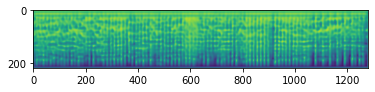

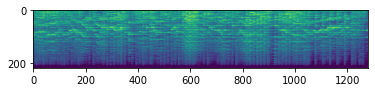

In [24]:
#TEST WRITE GENERATED AUDIO
import librosa
import scipy
import soundfile as sf

#get first recording
data = dataset.data[0]
spect = data[0][0]
sr = data[0][1]
mean = data[0][2]
var = data[0][3]

spect = spect.reshape(1,spect.size(0),spect.size(1),spect.size(2))
spect = spect.to(device)

#desired label - currently the same
label_onehot = torch.zeros(len(dataset.classes)) 
label_onehot[1] = 1
label_onehot = label_onehot.reshape(1,-1)
label_onehot = label_onehot.to(device)

#generate
y = generator(spect,label_onehot)

#show img - our output vs real recording
y = y.detach().cpu().numpy().reshape(y.size(2),y.size(3))
spect = spect.detach().cpu().numpy().reshape(spect.size(2),spect.size(3))
mean = mean.cpu().numpy()
var = var.cpu().numpy()
plt.imshow(y)
plt.show()
plt.imshow(spect)

#write file test.wav
dataloader.writeAudio(y, 22050,mean,var,'test_promena_stila')



In [ ]:
#TEST - LOAD AUDIO/WRITE AUDIO
spec,sr = dataloader.readAudio("C:\\Users\\psimluser\\Desktop\\PSIML6_Voice_style_transfer\\Data\\genres_original\\blues\\blues.00000.wav")
spect = spect[:,:1280] 
#mean = spect.mean()
#var = spect.var()
#spect = (spect-mean)/var
#dataloader.writeAudio(spect, 22050,mean,var,'meanvarselftest')
print(spect)

In [ ]:
spec,sr = dataloader.readAudio("C:\\Users\\psimluser\\Desktop\\PSIML6_Voice_style_transfer\\Data\\genres_original\\blues\\blues.00000.wav")
print(spec)
print(np.sqrt(spec.var()))
print(spec.mean())
print(spec.max())

In [ ]:
#y = y[0].detach().cpu().numpy().reshape(y.size(2),y.size(3))
#mean = mean[0].cpu().numpy()
#var = var[0].cpu().numpy()
print(y*var+mean)

In [27]:
torch.save(generator.state_dict(), 'generator_3cls_250ep_param1052.pt')
torch.save(discriminator.state_dict(), 'diskriminator_3cls_250ep_param1052.pt')